# A simplified Version of Project Lab2
## from Supplement A: Microwave Radiometer Temperature and Humidity Retrieval

In [1]:
import sys
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr
import scipy.stats as stats

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')

sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

/home/microway/anaconda3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/microway/anaconda3/lib/python3.9/abc.py:106: FutureWarning: xarray subclass customProfile should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [2]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature (or humidty) vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

In [3]:
prior = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')

/home/microway/anaconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# Load prior dataset
We start with loading the the previously prepared (see [lib/prepare_radiosondes.ipynb](lib/prepare_radiosondes.ipynb)) collection of radiosonde profiles at NSA from 04/2002 to 02/2020. We use the xarray library which provides a transparent interface to netCDF files so that we can directly copy the required variables form the netCDF file. The unit of temperature is Kelvin, specific humidity is provided in g/kg, and pressure is in Pa.


In [4]:
prior = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')

prior['q'] = np.log10(prior['q'])

profileTT = np.array([
    '2004-03-16T12:00:00.000000000', '2006-04-01T00:00:00.000000000',
    '2009-01-30T18:00:00.000000000', '2014-07-27T06:00:00.000000000',
    '2018-01-08T12:00:00.000000000'
],dtype='datetime64[ns]')

Yobs_time = '2006-04-01T00:00:00.000000000'

profiles = prior.sel(time=profileTT)
prior = prior.drop_sel(time=profileTT)
nLev = len(prior.height)

priors = {'all': prior}

years = [ 
           '2004', 
           '2005', 
           '2006', 
           '2007', 
           '2008', 
           '2009', 
           '2010', 
           '2011', 
           '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',]


Xa_year = '2003'

year_numbers = (
 
 [2004],
 [2005],
 [2006],
 [2007],
 [2008],
 [2009],
 [2010],
 [2011],
 [2012],
 [2013],
 [2014],
 [2015],
 [2016],
 [2017],
 [2018],
 [2019],
)
for year, year_number in zip(years, year_numbers):
    priors[year] = prior.where(
        np.in1d(prior['time.year'], year_number)[:, np.newaxis]).dropna(
            'time', how='all')

In [5]:
    
prior_qts = {}
for year in priors.keys():
    prior_q = priors[year]['q'].to_pandas()
    prior_q.columns = ['%05i_q' % (i) for i in prior_q.columns]
    prior_t = priors[year]['temp'].to_pandas()
    prior_t.columns = ['%05i_t' % (i) for i in prior_t.columns]
    prior_qts[year] = pn.concat((prior_q, prior_t), axis=1)
    prior_qts[year] = prior_qts[year].reindex(
        sorted(prior_qts[year].columns), axis=1)

# prior_qts

x_cov = []
x_mean = []

for year in ['all'] + years:

    x_cov1 = prior_qts[year].cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
    x_mean1 = prior_qts[year].mean().rename_axis('state', axis=0)

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))

x_cov = xr.concat(x_cov, dim='year')
x_mean = xr.concat(x_mean, dim='year')

x_cov['year'] = ['all'] + years
x_mean['year'] = ['all'] + years

for year in x_cov.year:
    assert np.linalg.matrix_rank(x_cov.sel(year=year).to_pandas()) ==  x_cov.shape[-1]
    
height = priors['all'].height

pressure = []
for k in ['all'] + years:
    pressure.append(priors[k].bar_pres.mean('time'))
pressure = xr.concat(pressure, dim='year')
pressure['year'] = ['all'] + years
pressure = pressure.to_pandas()

profiles_t = profiles['temp'].to_pandas()
profiles_t.columns = ['%05i_t' % (i) for i in profiles_t.columns]
profiles_q = profiles['q'].to_pandas()
profiles_q.columns = ['%05i_q' % (i) for i in profiles_q.columns]

x_truths = pn.concat((profiles_t, profiles_q), 1)
x_truths = x_truths.reindex(sorted(x_truths.index), axis=0)
x_truths.columns.name = 'state'
x_truths.index.name = 'time'

assert np.all(np.isfinite(x_truths))

frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]

y_vars = np.array(frequencies)
x_vars = x_mean.state.values

year = Xa_year  #Spring: March April May
profile = np.datetime64(Yobs_time)
x_truth = x_truths.loc[profile]

y_noise = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)

/tmp/ipykernel_428490/1820447172.py:47: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x_truths = pn.concat((profiles_t, profiles_q), 1)


  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.71 s, iteration 1, degrees of freedom: 4.72 of 120, not converged (x-space):  790.867
1.06 s, iteration 2, degrees of freedom: 4.69 of 120, not converged (x-space):  32.098
1.41 s, iteration 3, degrees of freedom: 4.69 of 120, converged (x-space):  0.309
1.76 s, iteration 4, degrees of freedom: 4.69 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.65 s, iteration 1, degrees of freedom: 4.71 of 120, not converged (x-space):  893.854
0.95 s, iteration 2, degrees of freedom: 4.68 of 120, not converged (x-space):  27.785
1.26 s, iteration 3, degrees of freedom: 4.67 of 120, converged (x-space):  0.250
1.57 s, iteration 4, degrees of freedom: 4.67 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.61 s, iteration 1, degrees of freedom: 4.64 of 120, not converged (x-space):  547.434
0.91 s, iteration 2, degrees of freedom: 4.61 of 120, not converged (x-space):  18.992
1.24 s, iteration 3, degrees of freedom: 4.60 of 120, converged (x-space):  0.137
1.55 s, iteration 4, degrees of freedom: 4.60 of 120, done.  0.000


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.61 s, iteration 1, degrees of freedom: 4.72 of 120, not converged (x-space):  830.625
0.91 s, iteration 2, degrees of freedom: 4.67 of 120, not converged (x-space):  37.928
1.22 s, iteration 3, degrees of freedom: 4.67 of 120, converged (x-space):  0.384
1.51 s, iteration 4, degrees of freedom: 4.67 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.60 s, iteration 1, degrees of freedom: 4.71 of 120, not converged (x-space):  1174.019
0.90 s, iteration 2, degrees of freedom: 4.67 of 120, not converged (x-space):  46.788
1.19 s, iteration 3, degrees of freedom: 4.66 of 120, converged (x-space):  0.515
1.49 s, iteration 4, degrees of freedom: 4.66 of 120, done.  0.002


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.60 s, iteration 1, degrees of freedom: 4.65 of 120, not converged (x-space):  900.763
0.90 s, iteration 2, degrees of freedom: 4.61 of 120, not converged (x-space):  31.115
1.21 s, iteration 3, degrees of freedom: 4.61 of 120, converged (x-space):  0.256
1.51 s, iteration 4, degrees of freedom: 4.61 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.62 s, iteration 1, degrees of freedom: 4.66 of 120, not converged (x-space):  666.026
0.92 s, iteration 2, degrees of freedom: 4.64 of 120, not converged (x-space):  22.963
1.23 s, iteration 3, degrees of freedom: 4.64 of 120, converged (x-space):  0.191
1.54 s, iteration 4, degrees of freedom: 4.64 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.68 s, iteration 1, degrees of freedom: 4.68 of 120, not converged (x-space):  793.620
1.03 s, iteration 2, degrees of freedom: 4.66 of 120, not converged (x-space):  33.829
1.33 s, iteration 3, degrees of freedom: 4.65 of 120, converged (x-space):  0.333
1.62 s, iteration 4, degrees of freedom: 4.65 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.64 s, iteration 1, degrees of freedom: 4.62 of 120, not converged (x-space):  1197.767
0.98 s, iteration 2, degrees of freedom: 4.58 of 120, not converged (x-space):  48.118
1.33 s, iteration 3, degrees of freedom: 4.58 of 120, converged (x-space):  0.479
1.67 s, iteration 4, degrees of freedom: 4.58 of 120, done.  0.002


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.64 s, iteration 1, degrees of freedom: 4.64 of 120, not converged (x-space):  856.134
0.95 s, iteration 2, degrees of freedom: 4.60 of 120, not converged (x-space):  28.664
1.29 s, iteration 3, degrees of freedom: 4.60 of 120, converged (x-space):  0.249
1.62 s, iteration 4, degrees of freedom: 4.60 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.60 s, iteration 1, degrees of freedom: 4.62 of 120, not converged (x-space):  675.208
0.89 s, iteration 2, degrees of freedom: 4.60 of 120, not converged (x-space):  24.666
1.22 s, iteration 3, degrees of freedom: 4.59 of 120, converged (x-space):  0.223
1.56 s, iteration 4, degrees of freedom: 4.60 of 120, done.  0.001


/home/microway/pyOptimalEstimation_examples/lib/supporting_routines.py:295: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (axA, axB) = plt.subplots(ncols=2, sharey=True,
/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.67 s, iteration 1, degrees of freedom: 4.79 of 120, not converged (x-space):  734.597
0.97 s, iteration 2, degrees of freedom: 4.76 of 120, not converged (x-space):  32.212
1.27 s, iteration 3, degrees of freedom: 4.75 of 120, converged (x-space):  0.314
1.57 s, iteration 4, degrees of freedom: 4.75 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.61 s, iteration 1, degrees of freedom: 4.70 of 120, not converged (x-space):  899.360
0.91 s, iteration 2, degrees of freedom: 4.68 of 120, not converged (x-space):  41.263
1.21 s, iteration 3, degrees of freedom: 4.67 of 120, converged (x-space):  0.479
1.51 s, iteration 4, degrees of freedom: 4.67 of 120, done.  0.002


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.60 s, iteration 1, degrees of freedom: 4.78 of 120, not converged (x-space):  1118.946
0.90 s, iteration 2, degrees of freedom: 4.74 of 120, not converged (x-space):  56.865
1.19 s, iteration 3, degrees of freedom: 4.74 of 120, converged (x-space):  0.892
1.49 s, iteration 4, degrees of freedom: 4.74 of 120, done.  0.007


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.60 s, iteration 1, degrees of freedom: 4.67 of 120, not converged (x-space):  1039.128
0.90 s, iteration 2, degrees of freedom: 4.63 of 120, not converged (x-space):  47.352
1.20 s, iteration 3, degrees of freedom: 4.63 of 120, converged (x-space):  0.504
1.50 s, iteration 4, degrees of freedom: 4.63 of 120, done.  0.002


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.61 s, iteration 1, degrees of freedom: 4.68 of 120, not converged (x-space):  696.709
0.92 s, iteration 2, degrees of freedom: 4.65 of 120, not converged (x-space):  26.905
1.23 s, iteration 3, degrees of freedom: 4.65 of 120, converged (x-space):  0.226
1.52 s, iteration 4, degrees of freedom: 4.65 of 120, done.  0.001


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)
  File "/tmp/ipykernel_428490/3602161085.py", line 8, in <cell line: 2>
    pyOE.invertMatrix(singularMatrix)


0.62 s, iteration 1, degrees of freedom: 4.69 of 120, not converged (x-space):  1125.147
0.92 s, iteration 2, degrees of freedom: 4.66 of 120, not converged (x-space):  66.786
1.22 s, iteration 3, degrees of freedom: 4.66 of 120, converged (x-space):  0.949
1.52 s, iteration 4, degrees of freedom: 4.66 of 120, done.  0.004


/home/microway/anaconda3/lib/python3.9/site-packages/pyOptimalEstimation/pyOEcore.py:1339: UserWarning: FixedFormatter should only be used together with FixedLocator
  sp4.set_xticklabels(xlabels)


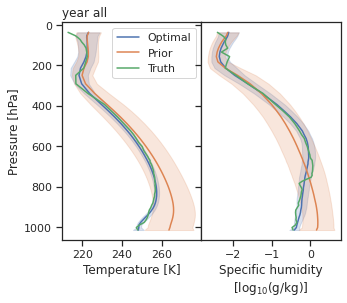

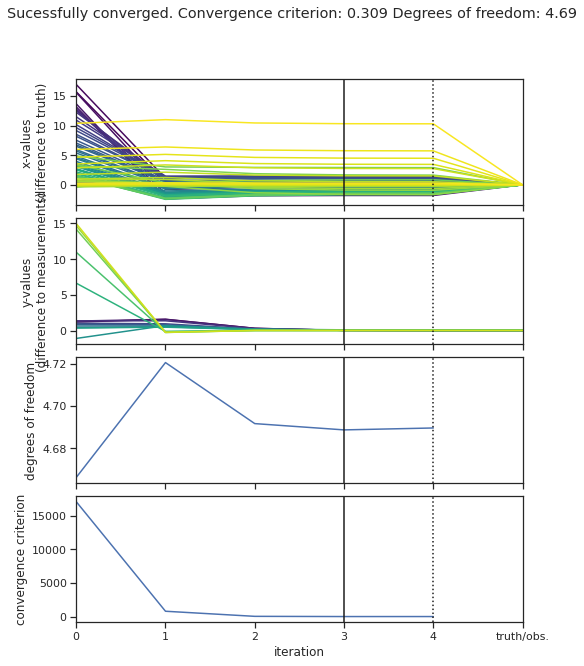

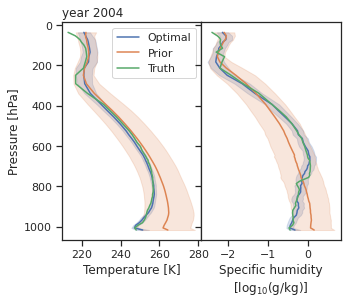

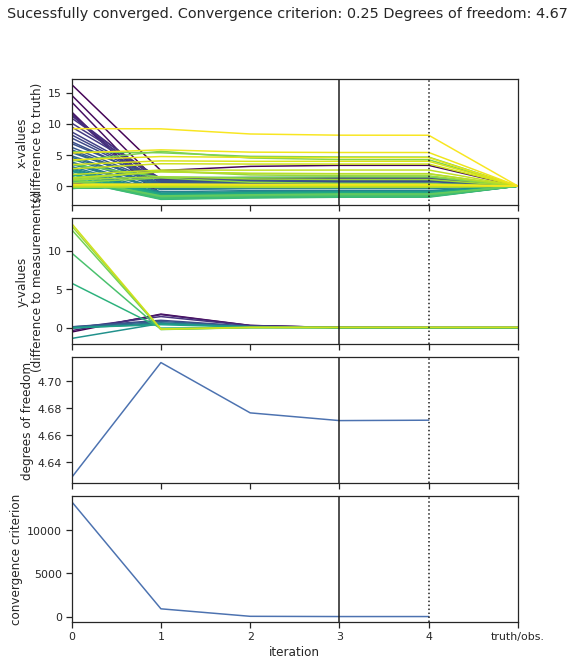

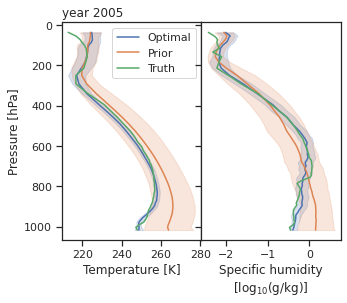

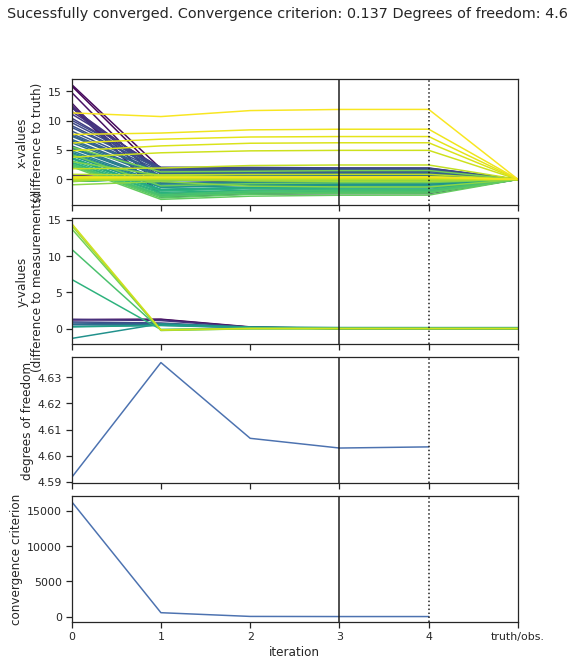

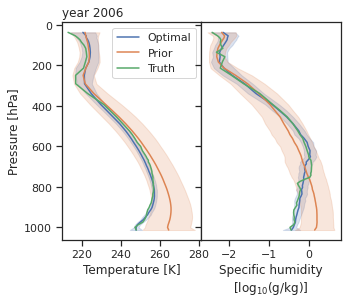

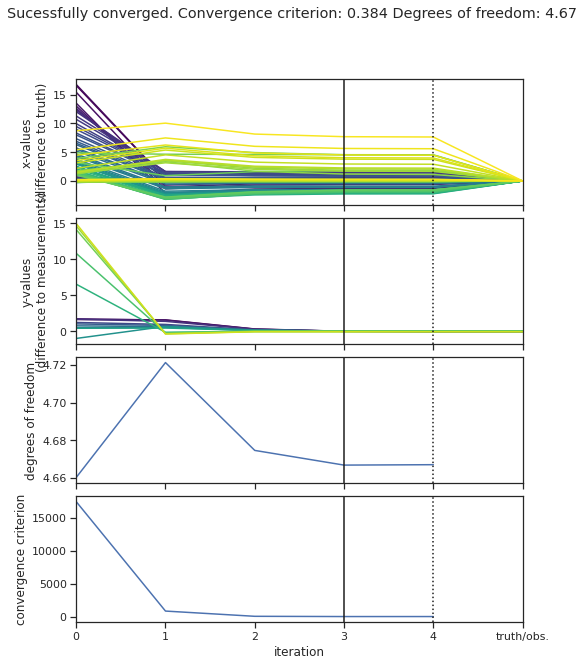

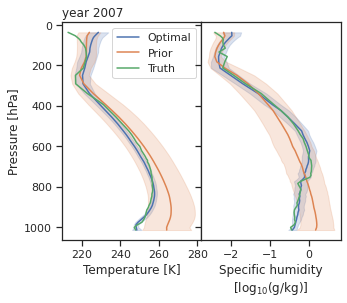

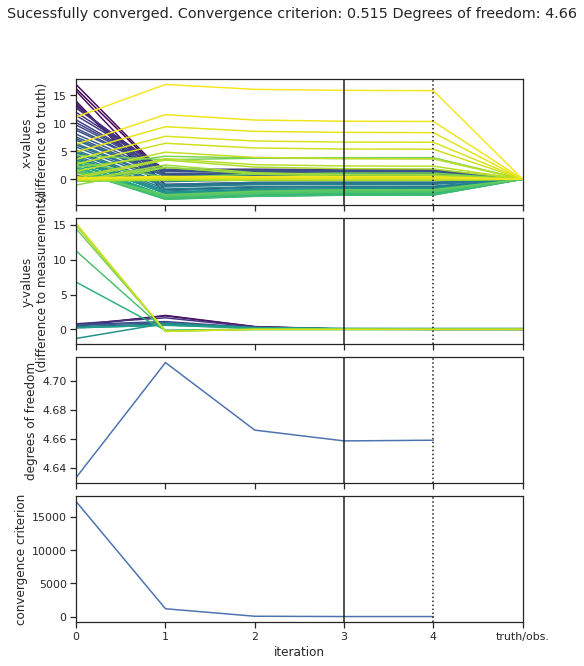

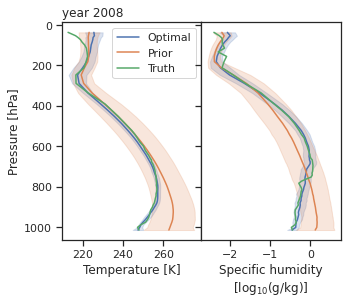

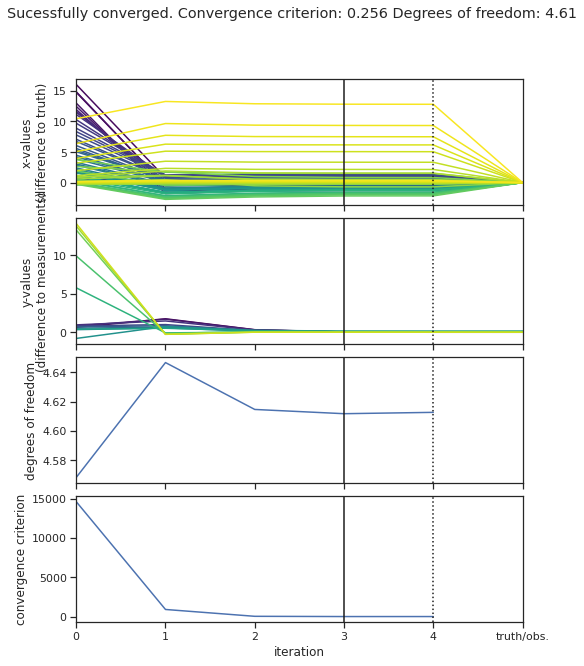

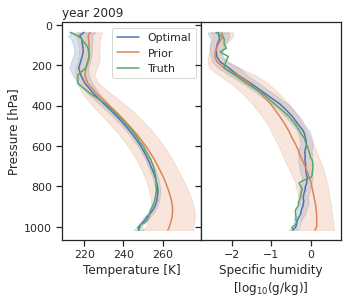

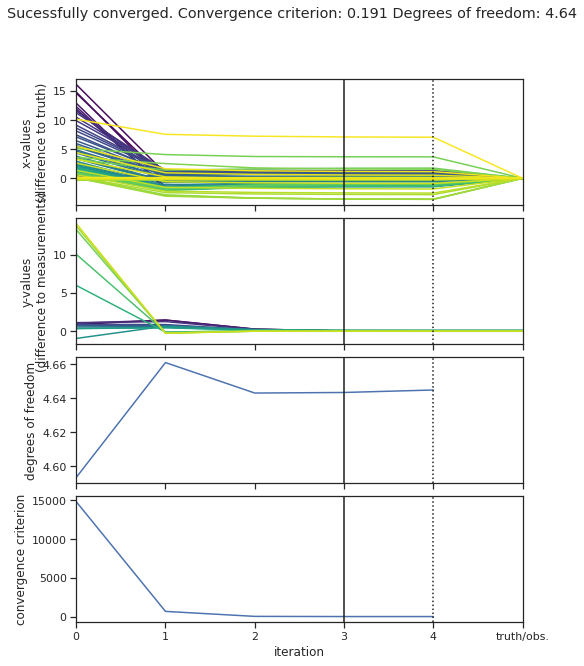

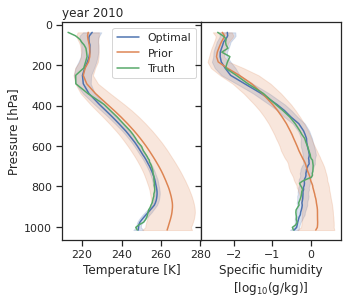

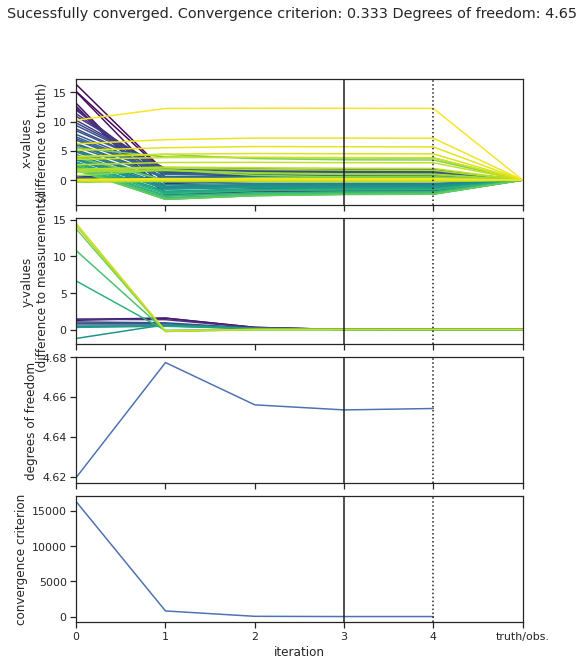

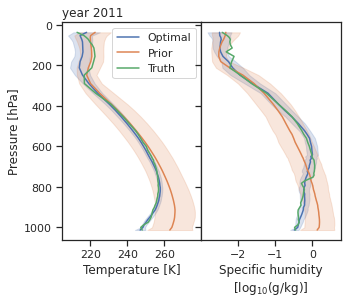

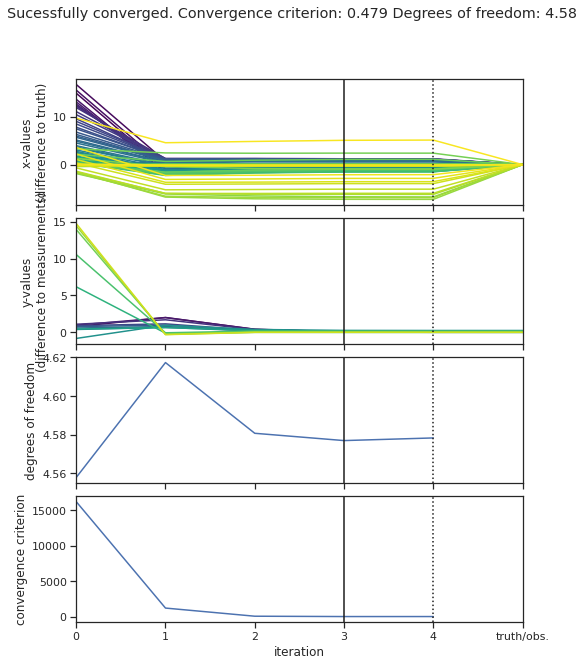

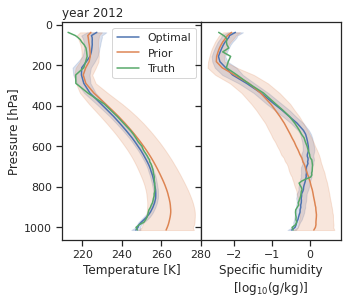

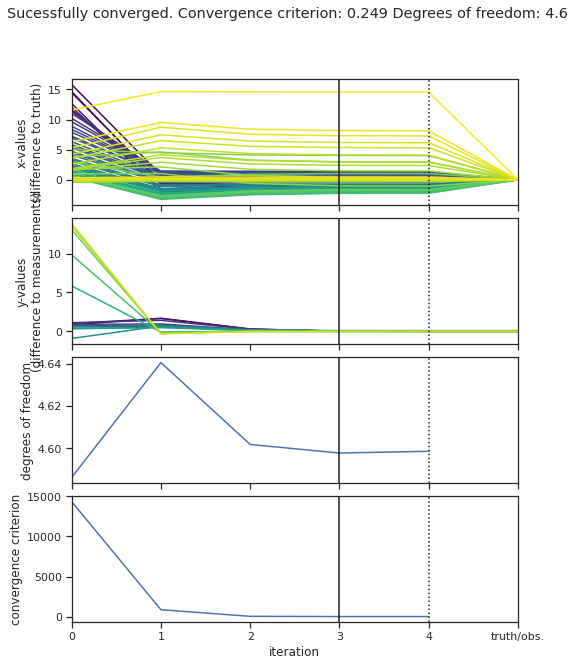

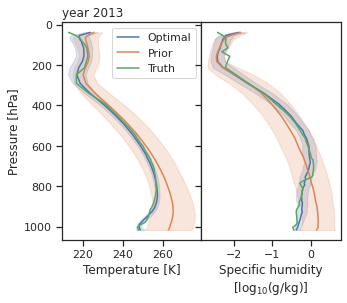

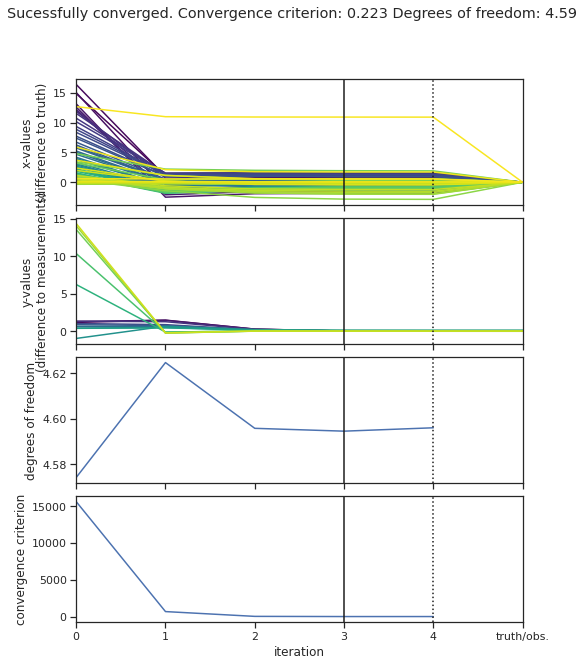

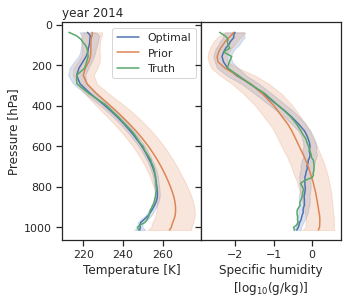

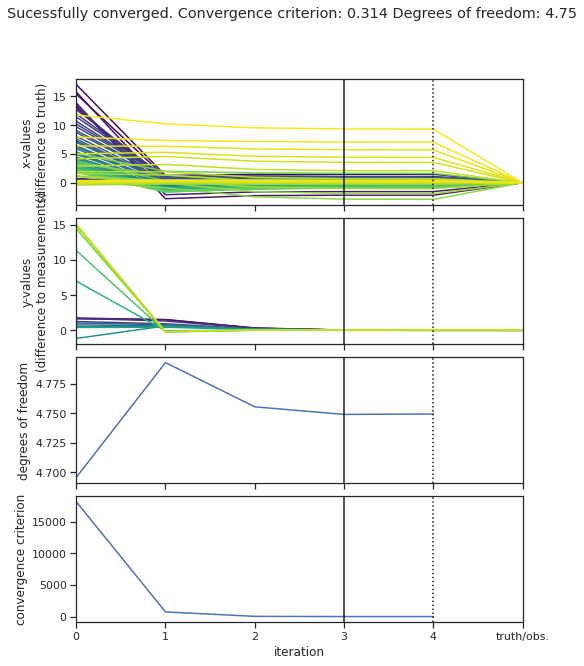

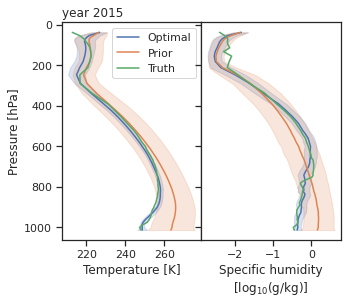

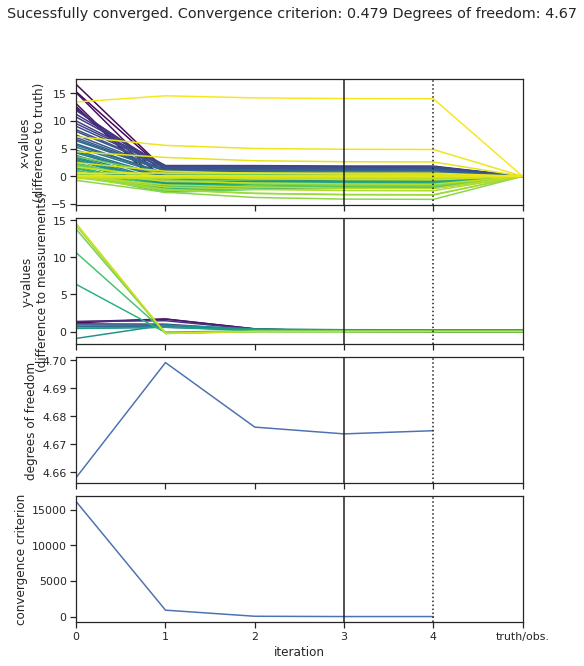

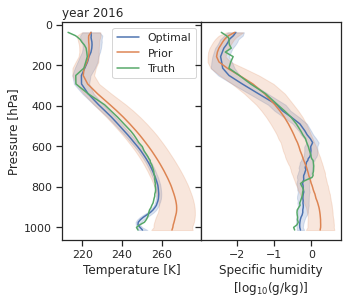

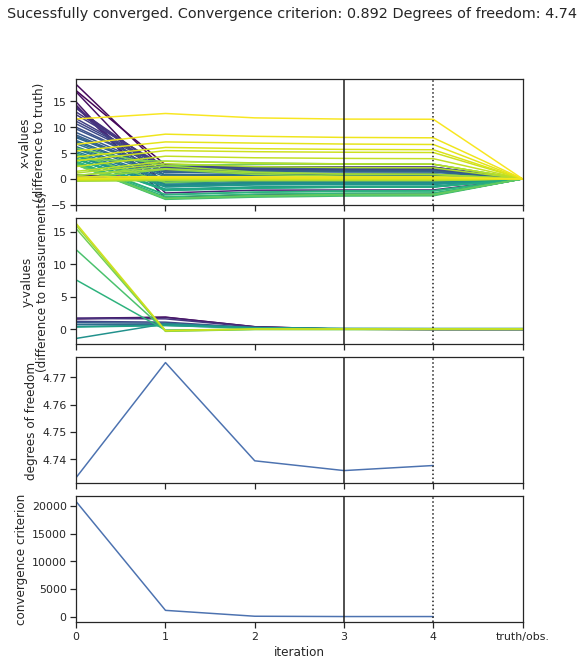

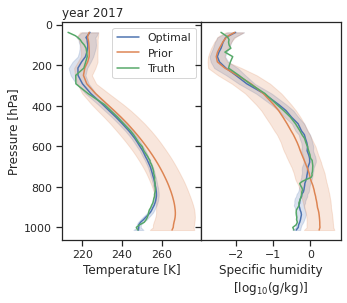

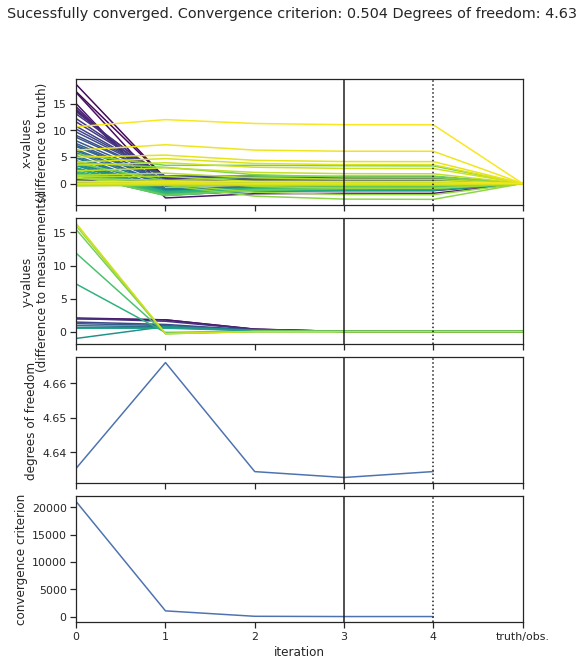

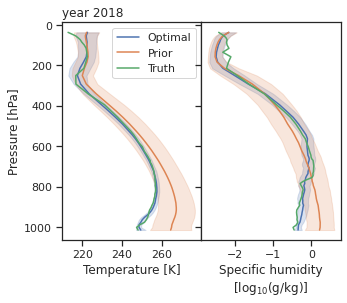

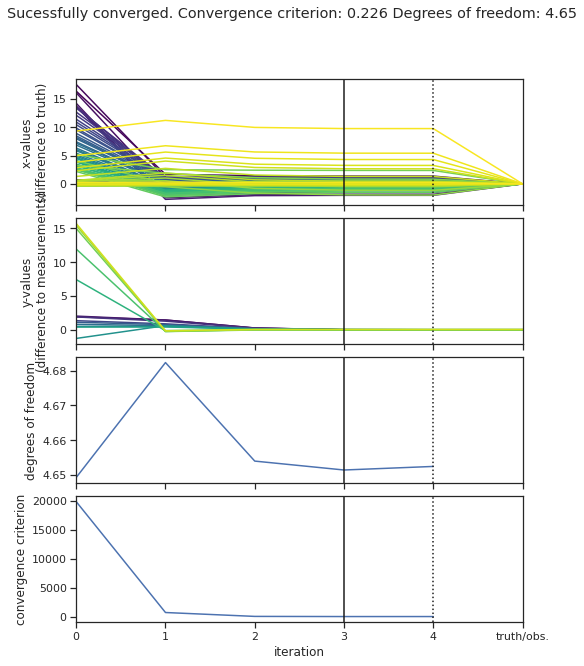

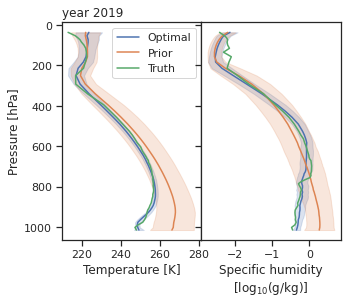

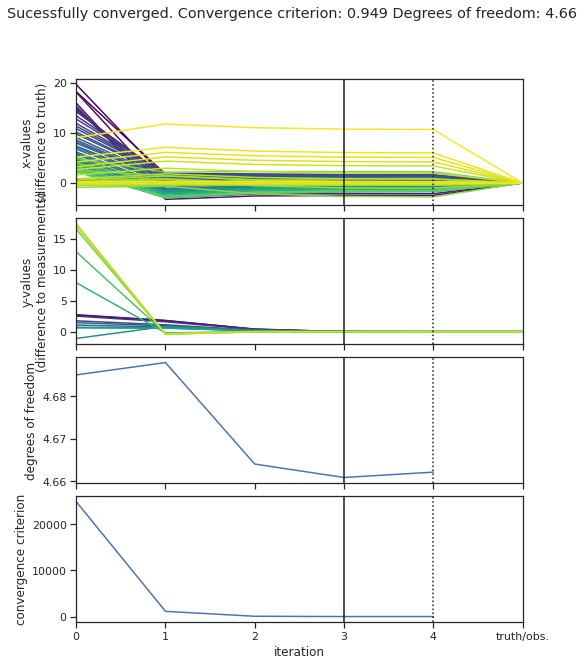

In [6]:
rms_year = []
for Xa_year in ['all'] + years:
    year = Xa_year
    x_a = x_mean.sel(year=Xa_year).to_pandas()[x_vars]
    S_a = x_cov.sel(year=Xa_year).to_pandas().loc[x_vars, x_vars]

    try:
        pyOE.invertMatrix(singularMatrix)
    except Exception as err:
        traceback.print_tb(err.__traceback__)

    forwardKwArgs = dict(
        pressure=pressure.loc[Xa_year].values,
        zenithAngle=0,
        frequencies=frequencies
    )

    y_obs = forwardRT(x_truth, **forwardKwArgs)
    y_obs = pn.Series(y_obs, index=y_vars)
    assert np.all(np.isfinite(y_obs))

    oe_ref = pyOE.optimalEstimation(
        x_vars, # state variable names
        x_a,  # a priori
        S_a, # a priori uncertainty
        y_vars,  # measurement variable names
        y_obs, # observations
        S_y, # observation uncertainty
        forwardRT, # forward Operator
        forwardKwArgs=forwardKwArgs, # additonal function arguments
        x_truth=x_truth, # true profile
    )

    oe_ref.doRetrieval()

    fig = supporting_routines.plotMwrResults(
        oe_ref,
        h=pressure.loc[year] / 100,
        hlabel='Pressure [hPa]',
        title='year '+str(year))
    fig.savefig('output/figures_q2_year/result_year_'+str(year))

    fig = oe_ref.plotIterations(legend=False, mode='difference')
    fig.savefig('output/figures_q2_year/iteration_year_'+str(year))

    T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
    T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

    rms_year.append(np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
#     print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
#     print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
#     print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

In [8]:
stat_year = pn.DataFrame()
stat_year ['year'] = ['all'] + years
stat_year ['rms'] = rms_year
print ('Yobs_time = ' + Yobs_time)
stat_year.to_csv('output/rms_year.csv', index=False) 
stat_year

Yobs_time = 2006-04-01T00:00:00.000000000


,year,rms
0,all,0.144171
1,2004,0.110111
2,2005,0.151697
3,2006,0.146687
4,2007,0.125459
5,2008,0.127808
6,2009,0.184855
7,2010,0.144246
8,2011,0.150528
9,2012,0.143242
